<a href="https://colab.research.google.com/github/LorenzoBioinfo/DrugDiscoveryML/blob/Dev/MolecularClassifier_USAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

######## Molecular Classifier
In this notebook, we will build several molecular classifiers for United States Adopted Names (USAN). USAN stems are name segments that provide information about a drug’s chemical structure or pharmacological activity. For example:

-caine: Local anesthetics

-cillin: Penicillin antibiotics

-olol: Beta-blockers

We will begin with a binary classification task and then extend the analysis to a multiclass classification problem. Different molecular fingerprinting strategies will be evaluated and compared.

Data are downloaded from "ML from drug discovery" repository of Noah Flynn.

In [69]:
import os
CHAPTER="ch01"
os.makedirs(f"artifacts/{CHAPTER}", exist_ok=True)
os.makedirs(f"data/{CHAPTER}", exist_ok=True)
os.makedirs(f"figures/{CHAPTER}", exist_ok=True)
os.makedirs(f"data/{CHAPTER}/fda_approved_drugs", exist_ok=True)
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs/-caine.csv" -O "data/ch01/fda_approved_drugs/-caine.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs/-cillin.csv" -O "data/ch01/fda_approved_drugs/-cillin.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs/-conazole.csv" -O "data/ch01/fda_approved_drugs/-conazole.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs/-olol.csv" -O "data/ch01/fda_approved_drugs/-olol.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs/-oxacin.csv" -O "data/ch01/fda_approved_drugs/-oxacin.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs/-pine.csv" -O "data/ch01/fda_approved_drugs/-pine.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs/-terol.csv" -O "data/ch01/fda_approved_drugs/-terol.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs/-tinib.csv" -O "data/ch01/fda_approved_drugs/-tinib.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs/-vir.csv" -O "data/ch01/fda_approved_drugs/-vir.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs/-sulfa.csv" -O "data/ch01/fda_approved_drugs/-sulfa.csv"

--2026-02-20 11:46:31--  https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs/-caine.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15131 (15K) [text/plain]
Saving to: ‘data/ch01/fda_approved_drugs/-caine.csv’

data/ch01/fda_appro 100%[===================>]  14.78K  --.-KB/s    in 0s      

2026-02-20 11:46:31 (89.5 MB/s) - ‘data/ch01/fda_approved_drugs/-caine.csv’ saved [15131/15131]

--2026-02-20 11:46:31--  https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs/-cillin.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.11

In [70]:
# Colab users only - Quick Install
!pip install -q rdkit numpy pandas matplotlib seaborn scikit-learn scipy tqdm jupyterlab umap-learn

In [71]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chemical informatics packages
from rdkit import Chem
from rdkit.Chem import (
    AllChem,
    Descriptors,
    Draw,
    PandasTools,
)

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
CHAPTER = "ch01"

# Set random seed for reproducibility
np.random.seed(41)

import warnings
warnings.filterwarnings("ignore")

In [72]:
def setup_visualization_style():
    """Configure consistent visualization style for the notebook"""
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette(sns.color_palette('PuBu'))
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 16

setup_visualization_style()
%matplotlib inline

In [73]:
def create_molecule_from_smiles(smiles):
    """
    Convert a SMILES string to an RDKit molecule object.

    Parameters:
    -----------
    smiles : str
        SMILES representation of a molecule

    Returns:
    --------
    rdkit.Chem.rdchem.Mol
        RDKit molecule object, or None if parsing fails
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Warning: Could not parse SMILES string: {smiles}")
    return mol

def display_molecule_properties(mol):
    """
    Display basic properties of an RDKit molecule object.

    Parameters:
    -----------
    mol : rdkit.Chem.rdchem.Mol
        RDKit molecule object
    """
    if mol is None:
        print("No valid molecule to display")
        return

    print(f"Chemical Formula: {Chem.rdMolDescriptors.CalcMolFormula(mol)}")
    print(f"Number of atoms: {mol.GetNumAtoms()}")
    print(f"Number of bonds: {mol.GetNumBonds()}")
    print(f"Number of rings: {Chem.rdMolDescriptors.CalcNumRings(mol)}")

    # Calculate basic molecular properties
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)

    print(f"Molecular Weight: {mw:.2f}")
    print(f"LogP: {logp:.2f}")
    print(f"Topological Polar Surface Area: {tpsa:.2f}")

In [74]:
def load_usan_stem_data(stems, data_path=f"data/{CHAPTER}/fda_approved_drugs"):
    """
    Load and combine data for multiple USAN stems.

    Parameters:
    -----------
    stems : list
        List of USAN stem strings to load
    data_path : str
        Base path to data files

    Returns:
    --------
    pandas.DataFrame
        Combined dataframe with all stem data
    """
    import os
    os.makedirs(data_path, exist_ok=True)

    dfs = []
    for stem in stems:
        try:
            df = pd.read_csv(
                f'{data_path}/{stem}.csv',
                sep=';',
                usecols=['Name', 'Smiles', '#RO5 Violations (Lipinski)'],
            )
            df['USAN Stem'] = stem
            dfs.append(df)
            print(f"✓ Loaded data for {stem}")
        except Exception as e:
            print(f"✗ Failed to load data for {stem}: {str(e)}")

    if not dfs:
        raise ValueError("No data was loaded. Check the file paths and formats.")

    return pd.concat(dfs)

# Define USAN stems we'll explore
usan_stems = [
    '-caine', '-cillin', '-conazole', '-olol',
    '-oxacin', '-pine', 'sulfa-', '-terol',
    '-tinib', '-vir'
]

In [75]:
try:
    fda_approved_df = load_usan_stem_data(usan_stems)
    print(f"\nLoaded data for {len(fda_approved_df)} drugs across {len(usan_stems)} USAN stems")

    # Display a summary of drugs per stem
    stem_counts = fda_approved_df.groupby('USAN Stem').size().sort_values(ascending=False)
    print("\nNumber of drugs per USAN stem:")
    print(stem_counts)

    # Save the combined data
    fda_approved_df.to_csv(f'data/{CHAPTER}/fda_approved_drugs/fda_approved_drugs.csv', sep=',', index=False)
    print("\nSaved combined data")
except Exception as e:
    print(f"Error loading data: {str(e)}")

✓ Loaded data for -caine
✓ Loaded data for -cillin
✓ Loaded data for -conazole
✓ Loaded data for -olol
✓ Loaded data for -oxacin
✓ Loaded data for -pine
✗ Failed to load data for sulfa-: [Errno 2] No such file or directory: 'data/ch01/fda_approved_drugs/sulfa-.csv'
✓ Loaded data for -terol
✓ Loaded data for -tinib
✓ Loaded data for -vir

Loaded data for 320 drugs across 10 USAN stems

Number of drugs per USAN stem:
USAN Stem
-tinib       60
-cillin      46
-vir         40
-olol        37
-caine       33
-terol       29
-oxacin      29
-conazole    24
-pine        22
dtype: int64

Saved combined data


We use here 3 different fingerprinting methods: Morgan, MACCS (166 bit,based on substructure ) and Topological Torsion.

In [76]:
def add_molecular_data(df, smiles_col='Smiles'):
    """
    Add RDKit molecule objects and fingerprints to a dataframe.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing SMILES strings
    smiles_col : str
        Column name containing SMILES strings

    Returns:
    --------
    pandas.DataFrame
        Dataframe with added molecular information
    """
    # Add molecule objects
    print("Adding RDKit molecule objects...")
    PandasTools.AddMoleculeColumnToFrame(df, smilesCol=smiles_col, molCol='ROMol')

    # Remove records with invalid molecules
    valid_mol_count = df['ROMol'].notnull().sum()
    invalid_mol_count = df['ROMol'].isnull().sum()
    print(f"Valid molecules: {valid_mol_count}")
    print(f"Invalid molecules: {invalid_mol_count}")

    if invalid_mol_count > 0:
        df = df[~df['ROMol'].isnull()]
        print(f"Removed {invalid_mol_count} records with invalid molecules")

    #
    print("Generating molecular fingerprints (this may take a moment)...")
    df['ECFP6'] = df['ROMol'].apply(
        lambda x: AllChem.GetMorganFingerprintAsBitVect(x, radius=3, nBits=1024)
    )

    # MACCS
    from rdkit.Chem import MACCSkeys
    df['MACCS'] = df['ROMol'].apply(
        lambda x: MACCSkeys.GenMACCSKeys(x)
    )

    # Topological
    from rdkit.Chem import RDKFingerprint

    df['Topological'] = df['ROMol'].apply(
        lambda x: RDKFingerprint(x)
    )


    print("Fingerprint generation complete")

    return df

fda_approved_df = add_molecular_data(fda_approved_df)

Adding RDKit molecule objects...
Valid molecules: 320
Invalid molecules: 0
Generating molecular fingerprints (this may take a moment)...


[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerator
[11:46:40] DEPRECATION WARNING: please use MorganGenerat

Fingerprint generation complete


In [77]:
fda_approved_df.head()

,Name,#RO5 Violations (Lipinski),Smiles,USAN Stem,ROMol,ECFP6,MACCS,Topological
0,ARTICAINE HYDROCHLORIDE,0,CCCNC(C)C(=O)Nc1c(C)csc1C(=O)OC.Cl,-caine,<rdkit.Chem.rdchem.Mol object at 0x78f0d6733f40>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, ..."
1,ETIDOCAINE HYDROCHLORIDE,0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C.Cl,-caine,<rdkit.Chem.rdchem.Mol object at 0x78f0d2309c40>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
2,ROPIVACAINE HYDROCHLORIDE,0,CCCN1CCCC[C@H]1C(=O)Nc1c(C)cccc1C.Cl,-caine,<rdkit.Chem.rdchem.Mol object at 0x78f0d23097e0>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
3,PROCAINE,0,CCN(CC)CCOC(=O)c1ccc(N)cc1,-caine,<rdkit.Chem.rdchem.Mol object at 0x78f0d2308b30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ..."
4,DIBUCAINE,0,CCCCOc1cc(C(=O)NCCN(CC)CC)c2ccccc2n1,-caine,<rdkit.Chem.rdchem.Mol object at 0x78f0d230b220>,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, ..."


######## PCA

In [85]:
def perform_pca_analysis(df, fingerprint_col='ECFP6', n_components=4):
    """
    Perform PCA on molecular fingerprints and add principal components to dataframe.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing molecular fingerprints
    fingerprint_col : str
        Column name containing fingerprints
    n_components : int
        Number of principal components to compute

    Returns:
    --------
    pandas.DataFrame
        Dataframe with added principal components
    sklearn.decomposition.PCA
        Fitted PCA model
    """
    print(f"Performing PCA with {n_components} components...")
    df = df.copy()
    # Extract fingerprints as a numpy array
    X = np.array([x for x in df[fingerprint_col]])

    # Initialize and fit PCA model
    pca = PCA(n_components=n_components, random_state=42)
    pca_result = pca.fit_transform(X)

    # Add principal components to dataframe
    for i in range(n_components):
        df[f'PC{i+1}'] = pca_result.T[i]

    # Display explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    print("Explained variance ratio by component:")
    for i, var in enumerate(explained_variance):
        print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")

    return df, pca


fda_approved_df_morgan, pca_model_morgan = perform_pca_analysis(fda_approved_df)
fda_approved_df_maccs, pca_model_maccs = perform_pca_analysis(fda_approved_df,fingerprint_col='MACCS')
fda_approved_df_topo, pca_model_topo = perform_pca_analysis(fda_approved_df,fingerprint_col='Topological')

Performing PCA with 4 components...
Explained variance ratio by component:
PC1: 0.0664 (0.0664 cumulative)
PC2: 0.0450 (0.1113 cumulative)
PC3: 0.0359 (0.1473 cumulative)
PC4: 0.0275 (0.1748 cumulative)
Performing PCA with 4 components...
Explained variance ratio by component:
PC1: 0.1355 (0.1355 cumulative)
PC2: 0.1266 (0.2621 cumulative)
PC3: 0.0761 (0.3382 cumulative)
PC4: 0.0607 (0.3990 cumulative)
Performing PCA with 4 components...
Explained variance ratio by component:
PC1: 0.1782 (0.1782 cumulative)
PC2: 0.0842 (0.2624 cumulative)
PC3: 0.0362 (0.2986 cumulative)
PC4: 0.0324 (0.3311 cumulative)


<Figure size 1200x1000 with 0 Axes>

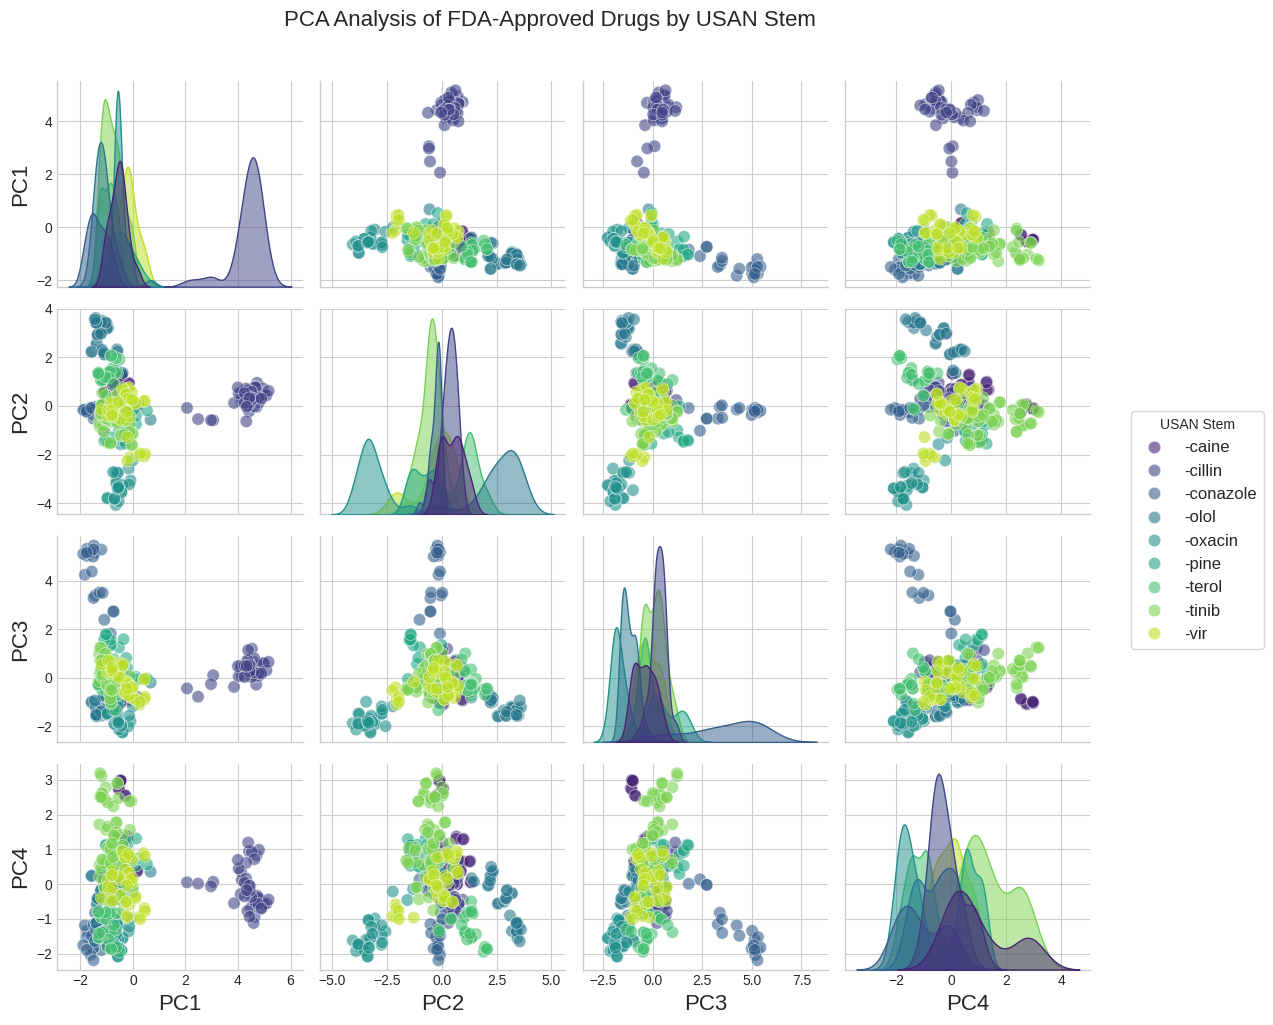

In [86]:
def plot_pca_results(df, group_col='USAN Stem', pc_cols=None):
    """
    Create visualizations of PCA results.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing PCA results
    group_col : str
        Column name for grouping/coloring
    pc_cols : list
        List of principal component columns to include

    Returns:
    --------
    matplotlib.figure.Figure
        Figure containing the visualization
    """
    if pc_cols is None:
        pc_cols = [f'PC{i+1}' for i in range(4)]

    # Create pairplot
    plt.figure(figsize=(12, 10))
    pairplot = sns.pairplot(
        df,
        hue=group_col,
        vars=pc_cols,
        height=2.5,
        palette='viridis',
        diag_kind='kde',
        plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'w', 'linewidth': 0.5},
        diag_kws={'alpha': 0.5, 'fill': True}
    )

    # Add title
    pairplot.figure.suptitle('PCA Analysis of FDA-Approved Drugs by USAN Stem',
                          y=1.02, fontsize=16)

    # Improve legend
    handles = pairplot._legend_data.values()
    labels = pairplot._legend_data.keys()

    pairplot._legend.remove()
    pairplot.figure.legend(handles=handles, labels=labels,
                       loc='center right', bbox_to_anchor=(1.15, 0.5),
                       frameon=True, fontsize=12, title='USAN Stem')

    pairplot.figure.tight_layout()
    return pairplot.fig

# Create and display PCA visualization
pca_fig = plot_pca_results(fda_approved_df_morgan)

<Figure size 1200x1000 with 0 Axes>

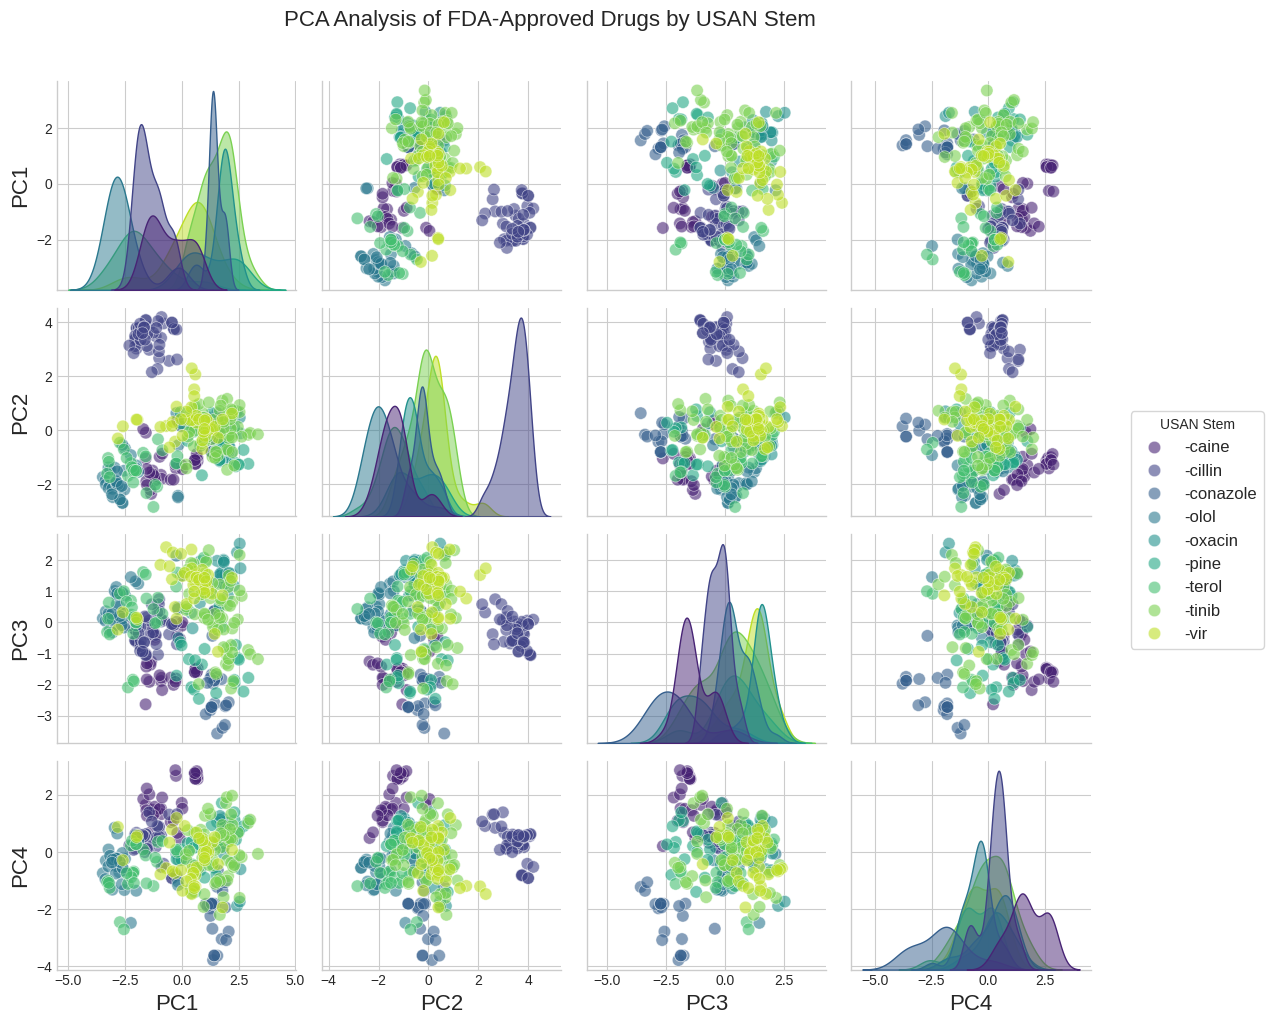

In [87]:
pca_fig = plot_pca_results(fda_approved_df_maccs)

In [ ]:
pca_fig = plot_pca_results(fda_approved_df_topo)

Plots are quite different,as expected, meaning that fingerprints capture different aspects of molecules.

ECFP6 (Morgan)
-Circular neighborhoods around each atom
-Captures local chemical environments and substructures
-Great for scaffold/fragment-based similarity

MACCS keys
-Predefined substructure patterns
-Only 166 bits → coarse-grained
-More interpretable but less detailed

Topological (RDKit) fingerprint
-Encodes paths of atoms in the molecule
-Sensitive to global connectivity rather than small local fragments


ECFP6 → molecules cluster by similar local fragments
MACCS → clusters may be broader, less precise
Topological → clusters may reflect overall molecular shape/connectivity

In [93]:
import umap
def perform_umap_analysis(df, fingerprint_col='ECFP6', n_components=2, n_neighbors=15, min_dist=0.1, random_state=42):
    """
    Perform UMAP on molecular fingerprints and add components to dataframe.

    Parameters:
    -----------
    df : pandas.DataFrame
    fingerprint_col : str
    n_components : int (di solito 2 per visualizzazione)
    n_neighbors : int – controlla quanto locale è la struttura preservata
    min_dist : float – quanto compatti sono i cluster (0.0 - 1.0)
    random_state : int

    Returns:
    --------
    pandas.DataFrame, umap.UMAP
    """
    print(f"Performing UMAP with {n_components} components...")

    df = df.copy()

    X = np.array([x for x in df[fingerprint_col]])

    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    umap_result = reducer.fit_transform(X)

    for i in range(n_components):
        df[f'UMAP{i+1}'] = umap_result.T[i]

    print(f"UMAP embedding shape: {umap_result.shape}")

    return df, reducer


# Utilizzo
fda_approved_df_morgan_umap, umap_model_morgan = perform_umap_analysis(fda_approved_df, fingerprint_col='ECFP6')
fda_approved_df_maccs_umap, umap_model_maccs   = perform_umap_analysis(fda_approved_df, fingerprint_col='MACCS')
fda_approved_df_topo_umap, umap_model_topo     = perform_umap_analysis(fda_approved_df, fingerprint_col='Topological')

Performing UMAP with 2 components...
UMAP embedding shape: (320, 2)
Performing UMAP with 2 components...
UMAP embedding shape: (320, 2)
Performing UMAP with 2 components...
UMAP embedding shape: (320, 2)


<Figure size 1200x1000 with 0 Axes>

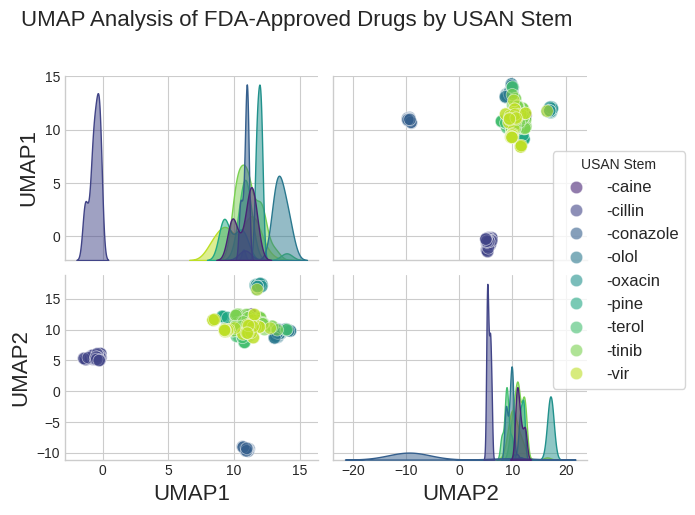

In [97]:
def plot_umap_results(df, group_col='USAN Stem',umap_cols=None):
    """
    Create visualizations of PCA results.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing UMAP results
    group_col : str
        Column name for grouping/coloring
    umap_cols : list
        List of umap columns to include

    Returns:
    --------
    matplotlib.figure.Figure
        Figure containing the visualization
    """
    if umap_cols is None:
        umap_cols = [f'UMAP{i+1}' for i in range(2)]

    # Create pairplot
    plt.figure(figsize=(12, 10))
    pairplot = sns.pairplot(
        df,
        hue=group_col,
        vars=umap_cols,
        height=2.5,
        palette='viridis',
        diag_kind='kde',
        plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'w', 'linewidth': 0.5},
        diag_kws={'alpha': 0.5, 'fill': True}
    )

    # Add title
    pairplot.figure.suptitle('UMAP Analysis of FDA-Approved Drugs by USAN Stem',
                          y=1.02, fontsize=16)

    # Improve legend
    handles = pairplot._legend_data.values()
    labels = pairplot._legend_data.keys()

    pairplot._legend.remove()
    pairplot.figure.legend(handles=handles, labels=labels,
                       loc='center right', bbox_to_anchor=(1.15, 0.5),
                       frameon=True, fontsize=12, title='USAN Stem')

    pairplot.figure.tight_layout()
    return pairplot.fig

# Create and display PCA visualization
pca_fig = plot_umap_results(fda_approved_df_morgan_umap)